In [1]:
import jax
import jax.numpy as jnp
import numpy as np
import hj_reachability as hj

In [2]:
from hj_reachability import dynamics
from hj_reachability import sets

class Drone2D(dynamics.ControlAndDisturbanceAffineDynamics):

  def __init__(self,
               k,
               g=9.8,
               u_bar=1.):
    self.k = k
    self.g = g
    control_mode = 'max'
    disturbance_mode = 'min'
    control_space = sets.Box(jnp.array([-u_bar]), jnp.array([u_bar]))
    disturbance_space = sets.Box(jnp.array([0.]), jnp.array([0.]))
    super().__init__(control_mode, disturbance_mode, control_space, disturbance_space)

  def open_loop_dynamics(self, state, time):
    _, v = state
    return jnp.array([v, -self.g])

  def control_jacobian(self, state, time):
    return jnp.array([[0.], [self.k]])

  def disturbance_jacobian(self, state, time):
    return jnp.array([[0.], [0.]])

In [3]:
# Different values of constant K that we will compute the value function for
ks = np.linspace(6, 12, 11, endpoint=True)

# Define the computation grid for numerically solving the PDE
grid = hj.Grid.from_lattice_parameters_and_boundary_conditions(
    hj.sets.Box(np.array([-0.5, -4.]),
                np.array([+3.5, +4.])),
    (51, 51))

# Define the implicit function l(x) for the failure set
failure_values = 1.5 - jnp.abs(grid.states[..., 0] - 1.5)

# Solver settings
times = np.linspace(0, -5, 11, endpoint=True)
solver_settings = hj.SolverSettings.with_accuracy('very_high',
                                                  hamiltonian_postprocessor=hj.solver.backwards_reachable_tube)

In [4]:
# Compute the value function by solving the PDE for each K
values = np.full((len(ks), len(times), 51, 51), fill_value=np.nan)

from tqdm import tqdm
for i, k in tqdm(enumerate(ks)):
  dynamics = Drone2D(k)
  values[i] = hj.solve(solver_settings, dynamics, grid, times, failure_values)

100%|##########|  5.0000/5.0 [00:00<00:00,  7.36sim_s/s]
100%|##########|  5.0000/5.0 [00:00<00:00,  7.09sim_s/s]
100%|##########|  5.0000/5.0 [00:00<00:00,  6.80sim_s/s]
100%|##########|  5.0000/5.0 [00:00<00:00,  6.72sim_s/s]
100%|##########|  5.0000/5.0 [00:00<00:00,  6.50sim_s/s]
100%|##########|  5.0000/5.0 [00:00<00:00,  6.10sim_s/s]
100%|##########|  5.0000/5.0 [00:00<00:00,  6.05sim_s/s]
100%|##########|  5.0000/5.0 [00:00<00:00,  6.13sim_s/s]
100%|##########|  5.0000/5.0 [00:00<00:00,  6.00sim_s/s]
100%|##########|  5.0000/5.0 [00:00<00:00,  5.95sim_s/s]
100%|##########|  5.0000/5.0 [00:00<00:00,  5.74sim_s/s]
11it [00:13,  1.25s/it]


In [5]:
import matplotlib.pyplot as plt
from ipywidgets import interact, FloatSlider

vbar = 1.5
def plot_value_function(k, t):
  ki = np.argwhere(np.isclose(ks, k)).item()
  ti = np.argwhere(np.isclose(times, t)).item()

  plt.figure()
  plt.title(f'$V(x, {t})$ for k={k}')
  plt.xlabel('$v_z$ (m/s)')
  plt.ylabel('$z$ (m)')

  plt.pcolormesh(
      grid.coordinate_vectors[1],
      grid.coordinate_vectors[0],
      values[ki, ti],
      cmap='RdBu',
      vmin=-vbar, vmax=vbar
  )
  plt.colorbar()
  plt.contour(
      grid.coordinate_vectors[1],
      grid.coordinate_vectors[0],
      values[ki, ti],
      levels=0,
      colors='k'
  )
  plt.contour(
      grid.coordinate_vectors[1],
      grid.coordinate_vectors[0],
      failure_values,
      levels=0,
      colors='r'
  )

interact(
    plot_value_function,
    k=FloatSlider(value=12., min=6., max=12., step=0.6),
    t=FloatSlider(value=0., min=-5., max=0., step=0.5)
)

interactive(children=(FloatSlider(value=12.0, description='k', max=12.0, min=6.0, step=0.6), FloatSlider(value…

<function __main__.plot_value_function(k, t)>

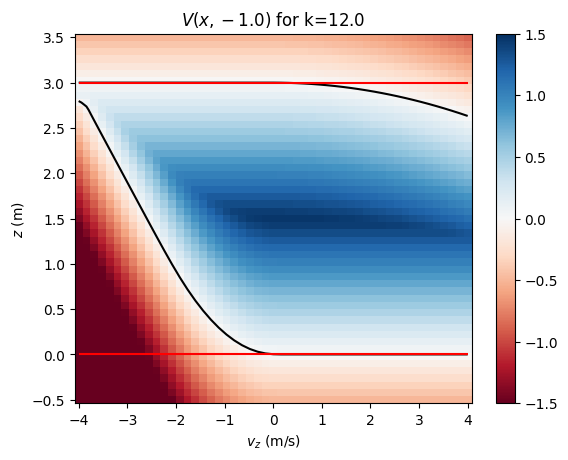

In [8]:
plot_value_function(12., -1.0)

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

from utils.model import SingleBVPNet
from mpc.dynamics import VerticalDroneDynamics 
from utils.util import compute_value_function_stagewise

In [7]:
def plot_value_function_gt(k, t, ax=None):
    ki = np.argwhere(np.isclose(ks, k)).item()
    ti = np.argwhere(np.isclose(times, t)).item()

    if ax is None:
        fig, ax = plt.subplots()

    pcm = ax.pcolormesh(
        grid.coordinate_vectors[1],
        grid.coordinate_vectors[0],
        values[ki, ti],
        cmap='RdBu',
        vmin=-vbar, vmax=vbar,
        shading='auto'
    )
    plt.colorbar(pcm, ax=ax,label=r"GT: $\hat{V}(z, \dot{z})$")

    ax.contour(
        grid.coordinate_vectors[1],
        grid.coordinate_vectors[0],
        values[ki, ti],
        levels=0,
        colors='lime',
        linewidths=2,
        linestyles='--'
    )
    ax.contour(
        grid.coordinate_vectors[1],
        grid.coordinate_vectors[0],
        failure_values,
        levels=0,
        colors='red',
        linewidths=2,
        linestyles='-.'
    )

    ax.set_title(f'$V(x, {t})$ for k={k}')
    ax.set_xlabel('$v_z$ (m/s)')
    ax.set_ylabel('$z$ (m)')


In [8]:
def compare_value_function_with_ground_truth(k, t, x_tensor, t_tensor, vbar, dynamics, models):
    z_vals = np.linspace(-0.5, 3.5, 200)
    vz_vals = np.linspace(-4.0, 4.0, 200)
    Z, VZ = np.meshgrid(z_vals, vz_vals, indexing='ij')

    with torch.no_grad():
        pred_V = compute_value_function_stagewise(x_tensor, t_tensor, dynamics, models)
        pred_V = pred_V.cpu().numpy().reshape(Z.shape)

    fig, ax = plt.subplots(figsize=(8, 6))
    ax.set_title(rf"$\hat{{V}}(z, \dot{{z}}, t={t:.1f})$ and $V(z, \dot{{z}}, t={t:.1f})$ for $k={k}$")
    # Call ground-truth plot using same axes
    plot_value_function_gt(k=k, t=t, ax=ax)

    pcm = ax.pcolormesh(vz_vals, z_vals, pred_V, shading='auto', cmap='RdBu', vmin=-vbar, vmax=vbar)
    fig.colorbar(pcm, ax=ax, label=r"Model: $\hat{V}(z, \dot{z})$")

    ax.contour(vz_vals, z_vals, pred_V, levels=[0], colors='black', linewidths=2, linestyles='-')
    ax.axhline(y=0.0, color='red', linestyle='--', linewidth=2)
    ax.axhline(y=3.0, color='red', linestyle='--', linewidth=2)

    

    safe_proxy = mlines.Line2D([], [], color='black', linestyle='-', label='Predicted $\hat{V}=0$')
    gt_proxy = mlines.Line2D([], [], color='lime', linestyle='--', label='Ground Truth $V=0$')
    fail_proxy = mlines.Line2D([], [], color='red', linestyle='--', label='Failure set')
    ax.legend(handles=[safe_proxy, gt_proxy, fail_proxy], loc='upper right')

    ax.set_xlabel(r"$\dot{z}$ (m/s)")
    ax.set_ylabel(r"$z$ (m)")
    ax.grid(True)
    plt.tight_layout()
    plt.show()


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
T = 0.2 # Start time
T_end = 1.2 # Final time
mT = T - T_end
K = 12.0  # Fixed gain
num_stages = 4
Np = 5
dynamics = VerticalDroneDynamics(device=device)
# ----------------------------
# Grid setup
# ----------------------------
z_vals = np.linspace(-0.5, 3.5, 200)
vz_vals = np.linspace(-4.0, 4.0, 200)
VZ, Z = np.meshgrid(vz_vals, z_vals) 
input_points = np.stack([Z.ravel(), VZ.ravel()], axis=1)  # Shape: [N, 2]

# Build input tensor with K and T
K_array = np.full((input_points.shape[0], 1), K)
T_array = np.full((input_points.shape[0], 1), T)
x_tensor = torch.tensor(np.hstack([input_points, K_array]), dtype=torch.float32).to(device)  # [N, 3]
t_tensor = torch.tensor(T_array, dtype=torch.float32).to(device)  # [N, 1]

#  ----------------------------
# Load all models from stage_1 to stage_(num_stages-1)
# ----------------------------
models = []
for stage in range(1, num_stages+1): 
    path = f'model_checkpoints_grid_search/stage_{stage}_progressive_{Np}_best.pt'
    # path = f'model_checkpoints_random_search/stage_{stage}_progressive_{Np}_best.pt'
    model = SingleBVPNet(
        in_features=4,
        out_features=1,
        hidden_features=512,
        num_hidden_layers=3
    ).to(device)
    model.load_state_dict(torch.load(path, map_location=device))
    model.eval()
    models.append(model)

Overpassing the stage 1
Overpassing the stage 2
Overpassing the stage 3
This value is in stage 4


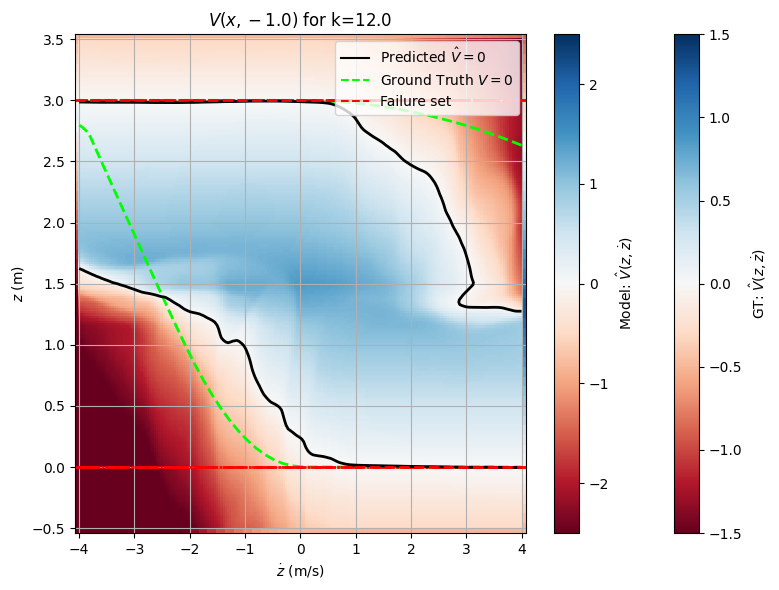

In [15]:
compare_value_function_with_ground_truth(
    k=12.0,
    t=-1.0,
    x_tensor = x_tensor,
    t_tensor = t_tensor,
    vbar=2.5,
    dynamics=dynamics,
    models=models
)
